In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import lightning as L
from lightning.pytorch import Trainer
from lightning.pytorch import loggers as pl_loggers
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from torchvision.transforms import v2
import torchvision
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torchgeo.datasets import RasterDataset, NonGeoDataset, IntersectionDataset, stack_samples, unbind_samples, random_bbox_assignment
from torchgeo.samplers import RandomGeoSampler, RandomBatchGeoSampler, GridGeoSampler
from torchgeo.datamodules import GeoDataModule
from torchgeo.datasets.utils import rgb_to_mask
import rasterio
import torchsummary
import os
import re
import shutil
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import rasterio

/home/edwmapa/miniconda3/envs/mlenv_nn/lib/python3.11/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [2]:
if torch.backends.mps.is_available():
	mps_device = torch.device("mps")
	x = torch.ones(1, device=mps_device)
	print(x)
elif torch.cuda.is_available():
	cuda_device = torch.device("cuda")
	x = torch.ones(1, device=cuda_device)
	print(x)

	print(torch.cuda.get_device_name(0))
	print('Memory Usage:')
	print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
	print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
	
else:
	print("MPS device not found.")

tensor([1.], device='cuda:0')
NVIDIA GeForce RTX 3070 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [4]:
def plot_images(base_plot_size=4, **images):
	n = len(images)
	siz = base_plot_size * n
	fig, axs = plt.subplots(1,n, figsize=(siz, base_plot_size))

	for i, (name, image) in enumerate(images.items()):
		if n > 1:
			axs[i].set_title(name)
			axs[i].imshow(image)
			axs[i].axis('off')
		else:
			axs.set_title(name)
			axs.imshow(image)
	plt.tight_layout()

## Data loaders 

In [5]:
seg_map_cmap = [
	(255, 255, 255), # 0. Impervious Surfaces
  (0,0, 255), # 1. Building
  (0, 255, 255), # 2. Low Vegetation
  (0, 255, 0), # 3. Tree
  (255, 255, 0), # 4. Car
  (255, 0, 0), # 5. Clutter/background
]

In [6]:
# Dataset root paths
postdam_path = '../datasets/isprs/Potsdam/'

In [7]:
# Postdam quick fix - add CRS info to segmentation maps

reprocess_segmentation = False

if reprocess_segmentation:
	postdam_source_img_names = [f for f in os.listdir(os.path.join(postdam_path, '2_Ortho_RGB')) if re.match('.*.tif',f)]

	for filename in postdam_source_img_names:
		target_filename = re.sub(r'_RGB.tif$', '_label.tif', filename)
		source_raster = rasterio.open(os.path.join(postdam_path, '2_Ortho_RGB', filename), 'r')
		
		target_raster = rasterio.open(os.path.join(postdam_path, '5_Labels_all', target_filename), 'r')
		h = target_raster.height # 6000
		w = target_raster.width # 6000
		count = target_raster.count # 3
		dtype = target_raster.dtypes[0] # 'uint8'
		data = target_raster.read()
		target_raster.close()
		
		with rasterio.open(
			os.path.join(postdam_path, '5_Labels_all', target_filename),
			'w',
			driver='GTiff',
			height=h,
			width=w,
			count=count,
			dtype=dtype,
			crs=source_raster.crs,
			transform=source_raster.transform,
		) as new_file:
			new_file.write(data)

	del data

In [8]:
def invserse_cmap(image, cmap):
  return torch.tensor(cmap)[image.numpy()].permute(2, 0, 1)

In [86]:
class RGBLoader(RasterDataset):
	filename_glob = '*.tif'
	is_image=True
	separate_files=False

class SegmentationMapLoader(RasterDataset):
	filename_glob = '*.tif'
	is_image=False # False means is a segmentation mask
	separate_files=False
	seg_map_cmap=seg_map_cmap
	one_hot=False

	def __getitem__(self, query):
		item = super().__getitem__(query)
		item['mask'] = item['mask'].permute(1, 2, 0)
		
		mask = torch.zeros(item['mask'].shape[:2], dtype=torch.int64)
		for i, c in enumerate(self.seg_map_cmap):
			cmask = item['mask'] == torch.tensor(c)
			mask[cmask.all(axis=-1)] = i

		item['mask'] = F.one_hot(mask).permute(2, 0, 1) if self.one_hot else mask.unsqueeze(0)
		return item


In [87]:
postdam_img_dataset = RGBLoader(os.path.join(postdam_path, '2_Ortho_RGB'))
postdam_seg_map_dataset = SegmentationMapLoader(os.path.join(postdam_path, '5_Labels_all'))


dataset = postdam_img_dataset & postdam_seg_map_dataset # Intersection Dataset

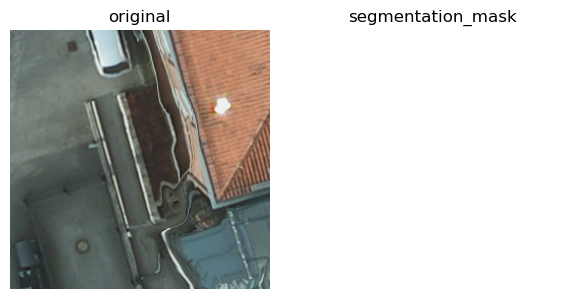

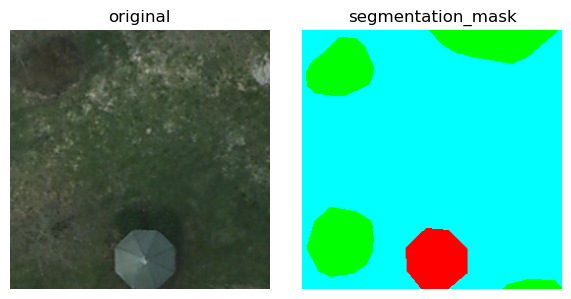

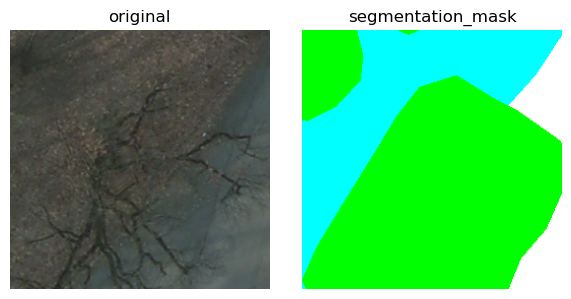

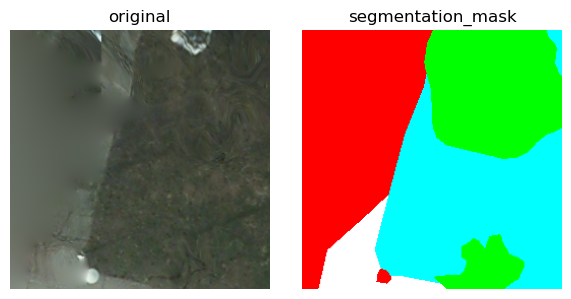

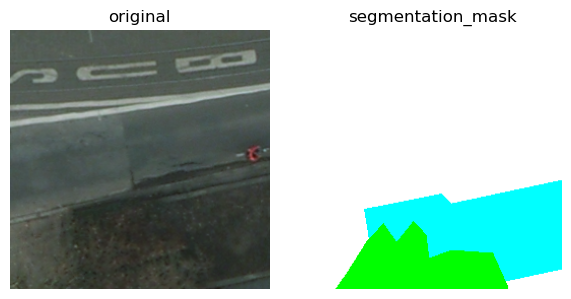

In [88]:
sampler = RandomGeoSampler(dataset, size=256, length=10) # patches of size 256, but resized by the transforms above
dataloader = DataLoader(dataset, sampler=sampler, collate_fn=stack_samples)

n=0
for sample in dataloader:
	if n==5: break
	
	image, gt = sample['image'], sample['mask']
	gt_to_color = invserse_cmap(gt.squeeze(), seg_map_cmap)

	plot_images(
		base_plot_size=3,
		original=v2.ToPILImage(mode='RGB')(image.squeeze()/255),
		segmentation_mask=v2.ToPILImage(mode='RGB')(gt_to_color/255),
	)
	n+=1

Lightning DataModule (GeoDataModule)

## Model (U-Net)

**Paper:** https://arxiv.org/pdf/1505.04597v1

**Related Readings:**
* Skip connections: https://theaisummer.com/skip-connections/
* Skip connections(cont.): https://www.analyticsvidhya.com/blog/2021/08/all-you-need-to-know-about-skip-connections/
* Segmentation Intro: https://www.jeremyjordan.me/semantic-segmentation/
* Satellital Imagery segmentation: https://towardsdatascience.com/u-net-for-semantic-segmentation-on-unbalanced-aerial-imagery-3474fa1d3e56/
* Convolution visualization: https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md (useful to see how the upsampling transposed convolution works)
* Batch Norm: https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739/

Other Implementations:
* https://github.com/milesial/Pytorch-UNet

Unet Architecture looks like this:

<img src="https://towardsdatascience.com/wp-content/uploads/2021/10/1eQLQo43suhzuHslqy-LL3g.png" width="800">

The key elements of a step in the "contraction" path of the architecture are:
* Double 3x3 convolutions at every step
* After the double convolutions, it has a 2x2 max pooling with stride 2 for downsampling
* After each downsample, the number of channels are doubled

The key elements of a step in the "expansive" path of the architecture are:
* 2x2 up-convolution that halves the number of channels (upscaling)
* We concatenate the corresponding feature maps of the contraction path to the upscaled maps.
  * Keep in mind that the concatenated maps are cropped because we miss border pixels on each convolution
  * Some authors handle the border issues by extending/reflecting/padding the images.
* We apply double 3x3 convolutions before the next upscaling.

At the end we apply a 1x1 convolution layer to map the resulting feature maps to the desired number of classes

In [16]:
# Double convolution block
class BlockConvolution(nn.Module):
	def __init__(self, in_channels, out_channels):
		super.__init__()
		self.model = nn.Sequential(
			nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1), # padding to avoid border issues
			nn.BatchNorm2d(out_channels), # Not required in the base architecture, but according to what we've read, it is useful to avoid gradient vanishing problems, stabilizes learning, etc.
			nn.ReLU(),
			nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1),
			nn.BatchNorm2d(out_channels),
			nn.ReLU()
		)
	
	def forward(self, x):
		return self.model(x)


class DownBlock(nn.Module):
	def __init__(self, in_channels, out_channels):
		super.__init__()
		self.model = nn.Sequential(
			nn.MaxPool2d(2),
			BlockConvolution(in_channels, out_channels)
		)
	
	def forward(self, x):
		return self.model(x)


class UpBlock(nn.Module):
	def __init__(self, in_channels, out_channels):
		# Reduce the number of in_channels by half and upscale image by twice de dimension
		self.upscale = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)

		# Conv (half of the in_channels come from the skip connections and the other half from the upscale)
		self.block_conv = BlockConvolution(in_channels, out_channels)

	def forward(self, x, x_skip):
		# x_skip are the weights of the corresponding down layer
		# Upscale
		x = self.upscale(x)
		
		# Pad upscaled (if necessary?)
		diffY = x_skip.size()[2] - x.size()[2]
		diffX = x_skip.size()[3] - x.size()[3]
		x = F.pad(x, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
		
		# Concat
		x = torch.cat([x_skip, x], dim=1)
		return self.block_conv(x)


class UNET(nn.Module):
	def __init__(self, in_channels, n_classes):
		super.__init__()
		self.contraction_layers = [
			BlockConvolution(in_channels, 64), # skips to D
			DownBlock(64, 128), # skips to C
			DownBlock(128, 256), # skips to B
			DownBlock(256, 512), # skips to A
			DownBlock(512, 1024), 
		]
		self.expansion_layers = [
			UpBlock(1024, 512), # A
			UpBlock(512, 256),  # B
			UpBlock(256, 128), # C
			UpBlock(128, 64) # D
		]
		self.out_layer = nn.Conv2d(64, n_classes, kernel_size=1) # Logits

	def forward(self, x):
		# Contraction
		x_c = [self.contraction_layers[0](x)]
		for f in self.contraction_layers[:1]:
			x_c.append(f(x_c[-1]))

		# Expansion
		x = self.expansion_layers[0](x_c[-1], x_c[-2]) # (x_to_upscale, skip_values)
		for i, f in enumerate(self.expansion_layers[1:]):
			skip_idx = len(self.contraction_layers) - 2 - i 
			x = f(x, x_c[skip_idx])
		
		return self.out_layer(x)


Define Lightning Module and DataModule

In [90]:
class RGBLoader(RasterDataset):
	filename_glob = '*.tif'
	is_image=True
	separate_files=False

class SegmentationMapLoader(RasterDataset):
	filename_glob = '*.tif'
	is_image=False # False means is a segmentation mask
	separate_files=False
	seg_map_cmap=seg_map_cmap
	one_hot=True

	def __getitem__(self, query):
		item = super().__getitem__(query)
		item['mask'] = item['mask'].permute(1, 2, 0)
		
		mask = torch.zeros(item['mask'].shape[:2], dtype=torch.int64)
		for i, c in enumerate(self.seg_map_cmap):
			cmask = item['mask'] == torch.tensor(c)
			mask[cmask.all(axis=-1)] = i

		item['mask'] = F.one_hot(mask).permute(2, 0, 1) if self.one_hot else mask.unsqueeze(0)
		print(mask.shape)
		return item


class CustomGeoDataModule(GeoDataModule): # Geodamatodule extends from torch lightning DataModules
	def __init__(self, **kwargs):
		super().__init__(
			dataset_class=kwargs['dataset_class'],
			batch_size=kwargs['batch_size'],
			patch_size=kwargs['patch_size'],
			length=kwargs['length'],
			num_workers=kwargs['num_workers'],
			**kwargs['dataset_class_kwargs']
		)
		# keep in mind that super method will set kwargs object attribute as kwargs['dataset_class_kwargs']
		self.split_faction = kwargs.get('split_fraction', [0.6, 0.2, 0.2])
		self.seed = kwargs.get('seed')

	def setup(self, stage):
		# self.dataset = self.dataset_class(**self.kwargs)
		self.dataset = self.kwargs['dataset1'] & self.kwargs['dataset2']

		generator = torch.Generator().manual_seed(self.seed)
		(self.train_dataset, self.val_dataset, self.test_dataset) = random_bbox_assignment(self.dataset, self.split_faction, generator)

		if stage in ["fit"]:
			self.train_batch_sampler = RandomBatchGeoSampler(self.train_dataset, self.patch_size, self.batch_size, self.length)
		if stage in ["fit", "validate"]:
			self.val_sampler = GridGeoSampler(self.val_dataset, self.patch_size, self.patch_size)
		if stage in ["test"]:
			self.test_sampler = GridGeoSampler(self.test_dataset, self.patch_size, self.patch_size)

In [ ]:
class UNETModel(L.LightningModule):
  def __init__(self):
    raise NotImplementedError

## Training

In [18]:
patch_size = 256 # Patch size
sample_size = 500
batch_size = 16
n_workers = 4
split_fraction = [0.8, 0.1, 0.1]


# Rescale factor
in_image_size = 128
out_image_size = 128

images_transforms = v2.Compose([
	v2.Resize(size=in_image_size),
	# lambda x: transform_image(x, [k2,k3], grayscale_mode=True),
])


segmentation_transforms = v2.Compose([
	v2.Resize(size=out_image_size, interpolation=torchvision.transforms.InterpolationMode.NEAREST_EXACT),
])


postdam_img_dataset = RGBLoader(os.path.join(postdam_path, '2_Ortho_RGB'), transforms=images_transforms)
postdam_seg_map_dataset = SegmentationMapLoader(os.path.join(postdam_path, '5_Labels_all'), transforms=segmentation_transforms)

datamodule = CustomGeoDataModule(
	dataset_class = IntersectionDataset,
	batch_size = batch_size, # GeoDataModule kwargs
	patch_size = patch_size, # GeoDataModule kwargs
	length = sample_size, # GeoDataModule kwargs
	num_workers = n_workers, # GeoDataModule kwargs
	dataset_class_kwargs = dict(
		dataset1 = postdam_img_dataset, # IntersectionDataset kwargs
		dataset2 = postdam_seg_map_dataset, # IntersectionDataset kwargs
		collate_fn = stack_samples, # IntersectionDataset kwargs
	),
	split_fraction=split_fraction,
	seed=12345,
)

## Eval